In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from deepchem import metrics
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import GridSearchCV


## Importing and splitting the data

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = bbb_df.drop(columns=["Drug", "SMILES", 'permeable'])
Y = bbb_df['permeable']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Building and training the model

In [4]:
SVM = SVC().fit(X_train, y_train)

train_prediction = SVM.predict(X_train)
test_prediction = SVM.predict(X_test)

#### Hyperparameter Optimization

In [5]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}


In [6]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ...................C=0.1, gamma=0.01, k

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             verbose=2)

In [7]:
print(grid.best_params_)


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


#### Optimized SVM

In [8]:
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

In [9]:
SVM_best.fit(X_train, y_train)
# make predictions for test data
y_pred = SVM_best.predict(X_test)

#### Feature Importances

In [10]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [11]:
feature_importance.tail(5)

,Feature,Importance
782,798,0.207953
769,784,0.210628
812,828,0.230212
403,412,0.246982
77,78,0.275957


Text(0.5, 1.0, 'Top 10 SVM Feature Importances')

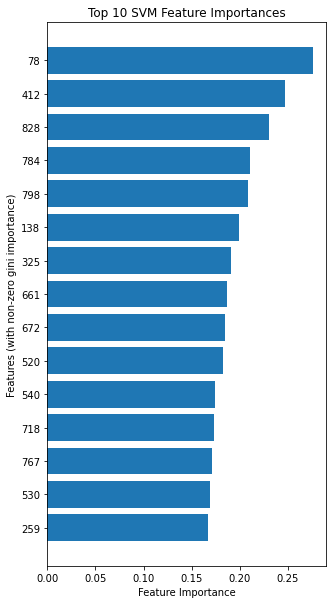

In [12]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Feature Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][990:], feature_importance['Importance'][990:])
plt.title('Top 10 SVM Feature Importances')

### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.963855421686747
Balanced Accuracy: 0.9158673469387755
ROC AUC: 0.9158673469387756
Precision Score: 0.961352657004831
Recall Score: 0.995



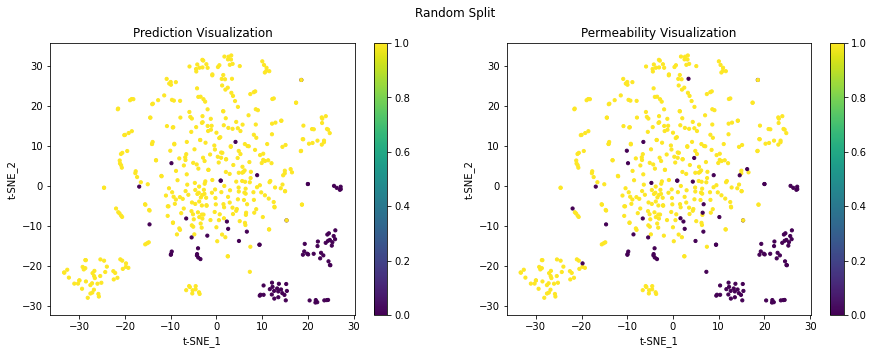

In [13]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [14]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [15]:
# Train SVM classifier
SVM_best = SVM_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = SVM_best.predict(test_scaff.X)

In [16]:
y_pred_scaff_prob = SVM_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
149,Clc1ccc(c(c1)Cl)/C(/Cl)=C/n1cncn1,0.999999
124,O=C(N1CCN(CC1)Cc1ccccc1)c1oc2ccccc2c1,0.999998
305,CCCCc1nc(c(n1Cc1ccc(cc1)c1ccccc1c1[nH]nnn1)CO)Cl,0.999997
150,Nc1nnc(c(n1)N)c1cccc(c1Cl)Cl,0.999997
63,CCN1CCC(C1)=C(c1ccccc1)c1ccccc1,0.999996
...,...,...
244,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000304
185,COC(=O)C1NC(=O)[C@H]2NC(=O)[C@H](NC(=O)[C@@H]3...,0.000264
184,CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(c(c2...,0.000127
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000089


### Scaffold Split PCA, DR, and Result Metrics

In [17]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [18]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8644578313253012
Balanced Accuracy: 0.8499559341950647
ROC AUC: 0.8499559341950647
Precision Score: 0.8116591928251121
Recall Score: 0.9836956521739131



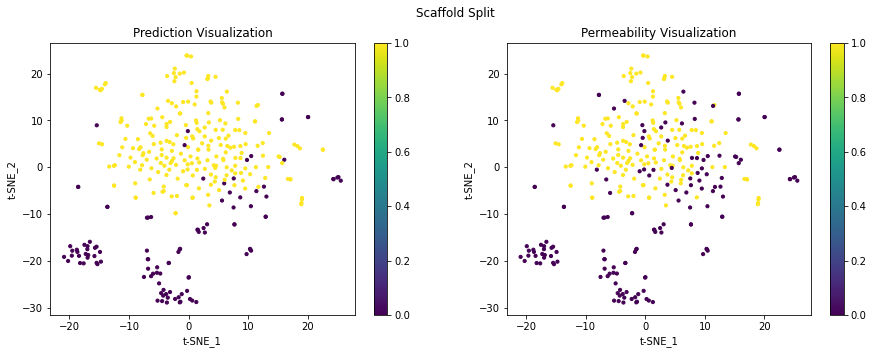

In [19]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [20]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [21]:
feature_importance

,Feature,Importance
5,5,-0.349273
346,357,-0.331275
399,410,-0.258262
306,315,-0.256448
624,640,-0.254354
...,...,...
564,580,0.172304
75,78,0.176783
516,530,0.183104
132,138,0.187629


Text(0.5, 1.0, 'Top 10 SVM Feature Importances')

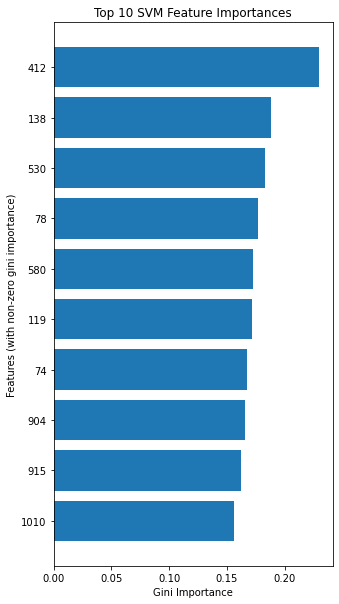

In [22]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 SVM Feature Importances')

In [23]:
feature_importance['Importance'][-20:].values.tolist()

[0.1337277939258662,
 0.13632480191369517,
 0.138932992356682,
 0.14083083565278967,
 0.14090059809093844,
 0.14105687830018293,
 0.14252462088136958,
 0.14328626822153895,
 0.14332839042503714,
 0.15200046517975518,
 0.155718651845881,
 0.16228580768768971,
 0.1657006992102551,
 0.16696688878562255,
 0.17180545468512864,
 0.17230446238075178,
 0.1767826144485264,
 0.18310378172584607,
 0.18762879433840352,
 0.22992676032314516]

In [24]:
top20 = feature_importance['Feature'][-20:].values.tolist()
top20 = [int(val) for val in top20]
top20

[835,
 935,
 667,
 245,
 672,
 520,
 155,
 144,
 249,
 646,
 1010,
 915,
 904,
 74,
 119,
 580,
 78,
 530,
 138,
 412]